In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  0


### Data Preparation

In [3]:
# get current directory
os.getcwd()

'/Users/JunhuaTan/Documents'

In [4]:
# get list of files in current directory
os.listdir()

['.ipynb_checkpoints',
 '20200121_mouseFacialExpr_v1',
 '20200121_mouseFacialExpr_v1.ipynb',
 'CNN-image-classifier.ipynb',
 'data-augmentation.ipynb',
 'MobileNet-with-Keras.ipynb']

In [5]:
# change directory
os.chdir('20200121_mouseFacialExpr_v1')

In [10]:
# check change
os.getcwd()

'C:\\Users\\Junhua\\Documents\\Lee Lab\\20200121_mouseFacialExpr_v1'

In [7]:
# Organize data into train, valid, test dirs
if os.path.isdir('train/neutral') is False:
    os.makedirs('train/neutral')
    os.makedirs('train/pain')
    os.makedirs('valid/neutral')
    os.makedirs('valid/pain')
    os.makedirs('test/neutral')
    os.makedirs('test/pain')

In [18]:
#random.sample(glob.glob('pain/pain*'), 120)

ValueError: Sample larger than population or is negative

In [19]:
# Organize data into train, valid, test dirs
for i in random.sample(glob.glob('pain/pain*'), 120):
    shutil.move(i, 'train/pain')      
for i in random.sample(glob.glob('neutral/neutral*'), 120):
    shutil.move(i, 'train/neutral')
for i in random.sample(glob.glob('pain/pain*'), 40):
    shutil.move(i, 'valid/pain')        
for i in random.sample(glob.glob('neutral/neutral*'), 40):
    shutil.move(i, 'valid/neutral')
for i in random.sample(glob.glob('pain/pain*'), 20):
    shutil.move(i, 'test/pain')      
for i in random.sample(glob.glob('neutral/neutral*'), 20):
    shutil.move(i, 'test/neutral')

In [20]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [21]:
# put data into format of keras generator
# ImageDataGenerator.flow_from_directory() returns a DirectoryIterator, 
# which generates batches of normalized tensor image data from the respective data directories.

# tf.keras.applications.vgg16.preprocess_input: apply preprocessing to images

# flow_from_directory(): pass and process our data
# target_size: resize images to desirable (height, weight)
# specify shuffle=False only for test_batches because
# we need to access the unshuffled labels for the test set for confusion matrix

# VGG16 Preprocessing: subtract the mean RGB value from training set to all pixels

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=train_path, 
                                     target_size=(224,224), 
                                     classes=['pain', 'neutral'], 
                                     batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=valid_path, 
                                     target_size=(224,224), 
                                     classes=['pain', 'neutral'], 
                                     batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
                .flow_from_directory(directory=test_path, 
                                     target_size=(224,224), 
                                     classes=['pain', 'neutral'], 
                                     batch_size=10, 
                                     shuffle=False)

Found 240 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [22]:
# grab 1 batch from train_batches
imgs, labels = next(train_batches)

In [23]:
# def from tensorflow
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

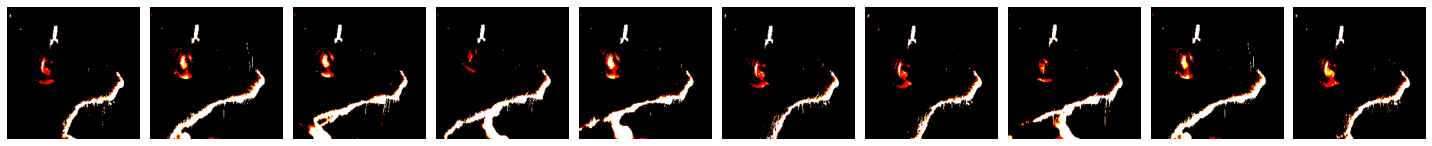

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [24]:
plotImages(imgs)
print(labels)

### Model Building

In [25]:
model = Sequential([
    # Conv2D: standard convolutional layer that accepts image data
    # filter number: arbitrary
    # kernel_size: 3*3 (normal for image data)
    # padding = 'same' (padding of 0's at border to maintain dimension)
    # input_shape: (height, weight, color channels)
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    # MaxPool2D: cut image dimensions in half
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    # flatten into 1D tensor before passing to output layer
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

In [27]:
# "categorical_crossentropy" or "binary_crossentropy" are both fine in this case
# "binary_crossentropy" needs only 1 single output node and sigmoid activation
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [28]:
# not specifying y here
# stored as generator: contained corresponding labels
model.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=2)

Train for 24 steps, validate for 8 steps
Epoch 1/10
24/24 - 9s - loss: 27.7620 - accuracy: 0.7833 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
24/24 - 8s - loss: 0.1769 - accuracy: 0.9875 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
24/24 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
24/24 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
24/24 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
24/24 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
24/24 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 8/10
24/24 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 9/10
24/24 - 8s - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 10/10


The model overfits the training data (low loss and high accuracy on training and higher loss and lower accuracy in validation).

### Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

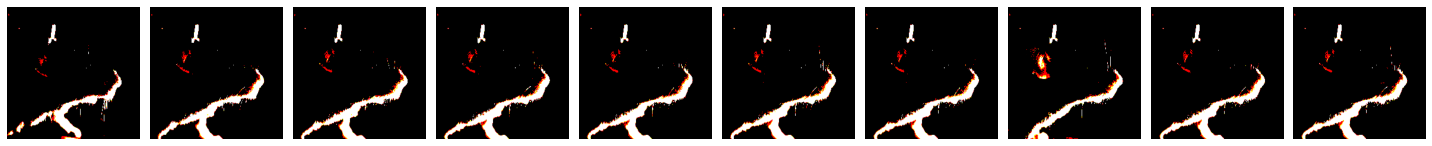

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [29]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [30]:
# unshuffled labels
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [31]:
predictions = model.predict(x=test_batches, verbose=0)

In [32]:
# [1., 0.] means predicting 0th element as having higher probability: output label cat
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [33]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [34]:
# def from scikit-learn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
test_batches.class_indices

{'pain': 0, 'neutral': 1}

Confusion matrix, without normalization
[[20  0]
 [ 0 20]]


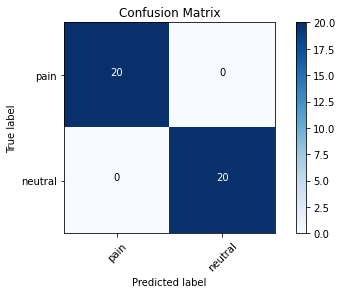

In [40]:
cm_plot_labels = ['pain','neutral']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Fine-Tune VGG16 Image Classifier With Keras

### Model Building

In [37]:
# download the model - need internet connection
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [38]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [39]:
type(vgg16_model)

tensorflow.python.keras.engine.training.Model

In [46]:
model = Sequential()

# iterate over each of the layers in vgg16_model, 
# except for the last layer, 
# and add each layer to the new Sequential model.
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [49]:
# freezing the trained weight from vgg16
for layer in model.layers:
    layer.trainable = False

In [50]:
model.add(Dense(units = 2, activation = 'softmax'))

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

### Train the fine-tuned VGG16 model

In [53]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [54]:
model.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=5, 
          verbose=2)

Train for 100 steps, validate for 20 steps
Epoch 1/5
100/100 - 106s - loss: 0.2692 - accuracy: 0.8990 - val_loss: 0.1867 - val_accuracy: 0.9350
Epoch 2/5
100/100 - 105s - loss: 0.1009 - accuracy: 0.9640 - val_loss: 0.1302 - val_accuracy: 0.9500
Epoch 3/5
100/100 - 105s - loss: 0.0630 - accuracy: 0.9810 - val_loss: 0.1126 - val_accuracy: 0.9650
Epoch 4/5
100/100 - 105s - loss: 0.0444 - accuracy: 0.9860 - val_loss: 0.1105 - val_accuracy: 0.9600
Epoch 5/5
100/100 - 102s - loss: 0.0331 - accuracy: 0.9910 - val_loss: 0.1054 - val_accuracy: 0.9600


### Predict using fine-tuned VGG16 model

In [55]:
predictions = model.predict(x=test_batches, verbose=0)

In [56]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [58]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[49  1]
 [ 0 50]]


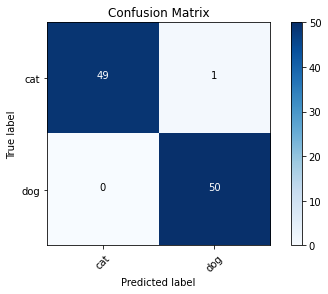